In [1]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv

In [2]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse
from scipy.sparse import coo_matrix
import numpy as np
import os


class OpenCloseDataset(Dataset):

    def __init__(self, datafolder, test=False, transform=None, pre_transform=None, k_degree=10):

        self.test = test
        self.datafolder = datafolder
        self.open = np.load(f'{datafolder}/raw/open_sorted.npy')
        self.close = np.load(f'{datafolder}/raw/close_sorted.npy')
        self.edge_attr = None #torch.from_numpy(np.load(f'{datafolder}/edge_attr.npy'))
        self.k_degree = k_degree

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['close_sorted.npy', 'open_sorted.npy']

    @property
    def processed_file_names(self):

        """ If these files are found in raw_dir, processing is skipped"""
        # todo test filenames
        if self.test:
            return [os.path.join(self.datafolder, 'processed', 'test', f'data_{i}.pt') for i in range(47+47)]

        else:
            return [os.path.join(self.datafolder, 'processed', f'data_{i}.pt') for i in range(47+47)]

    def download(self):
        pass

    def process(self):

        for index, matr in enumerate(self.open):
            _ = self._load_and_save(matr, index, 'open')

        for index, matr in enumerate(self.close):
            _ = self._load_and_save(matr, index, 'close')

    def _load_and_save(self, matr, index, state):

        x = torch.from_numpy(matr).float()

        if self.k_degree is not None:
            adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
            adj = torch.from_numpy(adj).float()
            edge_index, edge_attr = dense_to_sparse(adj)
            self.edge_attr = edge_attr
        else:
            edge_index = self._adjacency_threshold(x)

        label = torch.tensor(0 if state == 'close' else 1).long()

        data = Data(x=x, edge_index=edge_index, edge_attr=self.edge_attr, y=label)

        index = index + 47 if state == 'close' else index
        if self.test:
            torch.save(data,
                       os.path.join(self.processed_dir, 'test',
                                    f'data_{index}.pt'))
        else:
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))
        return data

    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix."""

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()

    def _adjacency_threshold(self, matr, threshold=0.5):
        # todo optimize ???
        idx = []
        for i in range(len(matr)):
            for j in range(len(matr)):
                if abs(matr[i, j]) > threshold:
                    idx.append((i, j))

        return torch.tensor(idx).long().t().contiguous()

    def len(self):
        return 47+47  # len(self.files)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data

In [3]:
full_dataset = OpenCloseDataset(datafolder='../data', k_degree=10).shuffle()
len(os.listdir('../data/processed'))

Processing...
Done!


96

In [6]:
full_dataset[0]

Data(x=[420, 420], edge_index=[2, 5966], edge_attr=[5966], y=1)

In [7]:
full_dataset[0].edge_attr

tensor([0.8917, 0.9328, 0.9397,  ..., 0.5268, 0.5075, 0.4597])

In [12]:
train_size = int(0.94 * len(full_dataset))
train_dataset, val_dataset = full_dataset[:train_size], full_dataset[train_size:]
val_dataset, test_dataset = val_dataset[:-3], val_dataset[-3:]

In [13]:
len(val_dataset)

3

In [14]:
model = GCN(full_dataset.num_features, 2, channels=[256, 32, 8], dropout=0.6).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 100
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


116282

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [16]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler)

  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 001, Train Loss: 0.0878, Test Loss 0.2239, Train Acc: 0.5114, Test Acc: 0.6667
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 002, Train Loss: 0.0863, Test Loss 0.2445, Train Acc: 0.5000, Test Acc: 0.3333
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 003, Train Loss: 0.0854, Test Loss 0.2346, Train Acc: 0.5455, Test Acc: 0.3333
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 004, Train Loss: 0.0852, Test Loss 0.2237, Train Acc: 0.5114, Test Acc: 0.6667
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 005, Train Loss: 0.0853, Test Loss 0.2442, Train Acc: 0.5000, Test Acc: 0.3333
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 006, Train Loss: 0.0829, Test Loss 0.2218, Train Acc: 0.5227, Test Acc: 0.6667
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 007, Train Loss: 0.0834, Test Loss 0.2371, Train Acc: 0.5568, Test Acc: 0.3333
Adjusting learning rate of group 0 to 1.0000e-03

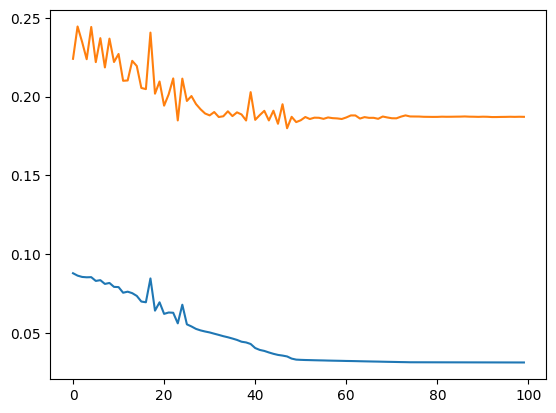

In [17]:
train_loss, val_loss = zip(*history)

plt.plot(train_loss)
plt.plot(val_loss);

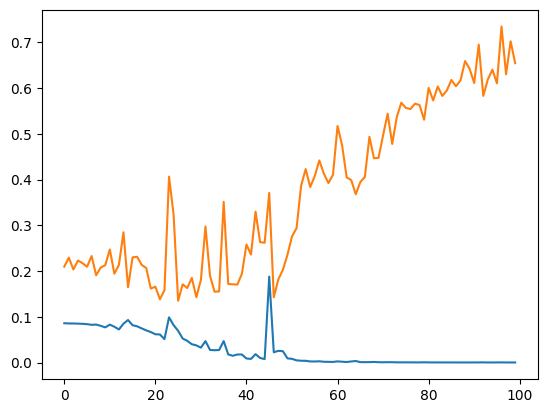

In [7]:
train_loss, val_loss = zip(*history)

plt.plot(train_loss)
plt.plot(val_loss);

In [18]:
model = GATv2(full_dataset.num_features, 128, 8).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 100
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=False)
sum(p.numel() for p in model.parameters())

220210

In [19]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0890, Test Loss 0.2161, Train Acc: 0.5114, Test Acc: 0.6667
Epoch: 002, Train Loss: 0.0881, Test Loss 0.2469, Train Acc: 0.5227, Test Acc: 0.3333
Epoch: 003, Train Loss: 0.0852, Test Loss 0.2168, Train Acc: 0.5341, Test Acc: 0.6667
Epoch: 004, Train Loss: 0.0852, Test Loss 0.2180, Train Acc: 0.5341, Test Acc: 0.6667
Epoch: 005, Train Loss: 0.0834, Test Loss 0.2298, Train Acc: 0.6023, Test Acc: 0.6667
Epoch: 006, Train Loss: 0.0831, Test Loss 0.2197, Train Acc: 0.5795, Test Acc: 0.6667
Epoch: 007, Train Loss: 0.0823, Test Loss 0.2334, Train Acc: 0.5795, Test Acc: 0.3333
Epoch: 008, Train Loss: 0.0815, Test Loss 0.2140, Train Acc: 0.5455, Test Acc: 0.6667
Epoch: 009, Train Loss: 0.0819, Test Loss 0.2136, Train Acc: 0.5568, Test Acc: 0.6667
Epoch: 010, Train Loss: 0.0764, Test Loss 0.2150, Train Acc: 0.7273, Test Acc: 0.6667
Epoch: 011, Train Loss: 0.0759, Test Loss 0.2191, Train Acc: 0.6591, Test Acc: 0.6667
Epoch: 012, Train Loss: 0.0746, Test Loss 0.2103, Trai

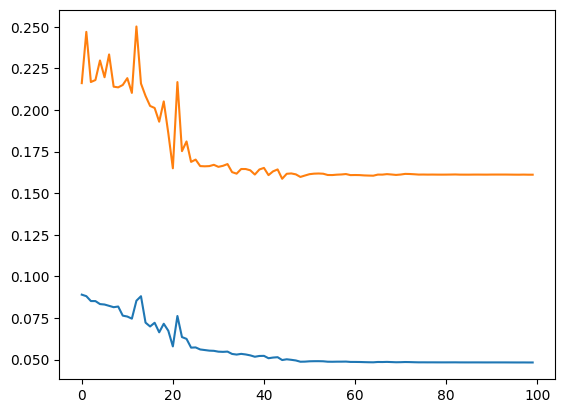

In [20]:
train_loss, val_loss = zip(*history)

plt.plot(train_loss)
plt.plot(val_loss);

In [15]:
train_loss, val_loss = zip(*history)

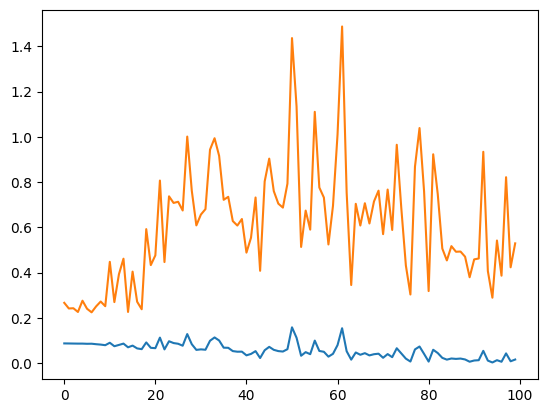

In [16]:
plt.plot(train_loss)
plt.plot(val_loss);

In [17]:
torch.save(model.state_dict(), '../weights/gat_2heads_128_8_knn30.pt')

In [135]:
torch.save(model.state_dict(), '../weights/bs8_128_32_8_k5.pt')

In [10]:
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [full_dataset[i].y for i in range(len(full_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GCN(full_dataset.num_features, 2, channels=[256, 32, 8], dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=50//4, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(50):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

Epoch: 000, Train Loss: 0.0865, Test Loss 0.2112, Train Acc: 0.4545, Test Acc: 0.6667
Epoch: 001, Train Loss: 0.0863, Test Loss 0.2283, Train Acc: 0.4886, Test Acc: 0.3333
Epoch: 002, Train Loss: 0.0859, Test Loss 0.2202, Train Acc: 0.5114, Test Acc: 0.6667
Epoch: 003, Train Loss: 0.0856, Test Loss 0.2265, Train Acc: 0.5227, Test Acc: 0.6667
Epoch: 004, Train Loss: 0.0854, Test Loss 0.2065, Train Acc: 0.5568, Test Acc: 1.0000
Epoch: 005, Train Loss: 0.0848, Test Loss 0.2246, Train Acc: 0.5455, Test Acc: 0.6667
Epoch: 006, Train Loss: 0.0840, Test Loss 0.2156, Train Acc: 0.6136, Test Acc: 0.6667
Epoch: 007, Train Loss: 0.0831, Test Loss 0.2139, Train Acc: 0.6364, Test Acc: 0.6667
Epoch: 008, Train Loss: 0.0820, Test Loss 0.2101, Train Acc: 0.6477, Test Acc: 0.6667
Epoch: 009, Train Loss: 0.0819, Test Loss 0.2072, Train Acc: 0.6364, Test Acc: 0.6667
Epoch: 010, Train Loss: 0.0820, Test Loss 0.1909, Train Acc: 0.6136, Test Acc: 1.0000
Epoch: 011, Train Loss: 0.0778, Test Loss 0.2059, Trai

In [11]:
eval_metrics

array([[0.66666667, 0.67333333, 0.08137704],
       [1.        , 0.72      , 0.13920409],
       [1.        , 0.59333333, 0.18      ],
       [1.        , 0.86666667, 0.17638342],
       [1.        , 0.66666667, 0.11547005],
       [1.        , 0.68666667, 0.1034945 ],
       [1.        , 0.68      , 0.09333333],
       [1.        , 0.85333333, 0.23247461],
       [1.        , 0.86666667, 0.25819889],
       [0.66666667, 0.7       , 0.1       ]])

In [16]:
np.mean(eval_metrics[:, 0]), np.std(eval_metrics[:, 0])

(0.9333333333333332, 0.13333333333333336)

In [18]:
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.7306666666666666, 0.0915641851380768)

In [19]:
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [full_dataset[i].y for i in range(len(full_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GATv2(full_dataset.num_features, 128, 8).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=50//4, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(50):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.0872, Test Loss 0.2138, Train Acc: 0.5000, Test Acc: 0.6667
Epoch: 001, Train Loss: 0.0851, Test Loss 0.2342, Train Acc: 0.5909, Test Acc: 0.3333
Epoch: 002, Train Loss: 0.0846, Test Loss 0.2182, Train Acc: 0.5227, Test Acc: 0.6667
Epoch: 003, Train Loss: 0.0813, Test Loss 0.2223, Train Acc: 0.6591, Test Acc: 0.6667
Epoch: 004, Train Loss: 0.0795, Test Loss 0.2135, Train Acc: 0.6818, Test Acc: 0.6667
Epoch: 005, Train Loss: 0.0826, Test Loss 0.2691, Train Acc: 0.5455, Test Acc: 0.3333
Epoch: 006, Train Loss: 0.0795, Test Loss 0.1939, Train Acc: 0.6364, Test Acc: 1.0000
Epoch: 007, Train Loss: 0.0734, Test Loss 0.2276, Train Acc: 0.7045, Test Acc: 0.6667
Epoch: 008, Train Loss: 0.0764, Test Loss 0.2646, Train Acc: 0.6477, Test Acc: 0.3333
Epoch: 009, Train Loss: 0.0801, Test Loss 0.2904, Train Acc: 0.5909, Test Acc: 0.3333
Epoch: 010, Train Loss: 0.0687, Test Loss 0.1715, Train Acc: 0.7500, Test Acc: 1.0000
Epoch: 011, Train Loss: 0.0715, Test Loss 0.1550, Tr

In [20]:
eval_metrics

array([[0.66666667, 0.65333333, 0.11469767],
       [1.        , 0.85333333, 0.25086517],
       [0.66666667, 0.61333333, 0.16812694],
       [1.        , 0.93333333, 0.18856181],
       [0.66666667, 0.64666667, 0.07916228],
       [1.        , 0.89333333, 0.21540659],
       [0.66666667, 0.87333333, 0.2096558 ],
       [0.66666667, 0.64666667, 0.1034945 ],
       [1.        , 0.9       , 0.20275875],
       [1.        , 0.96      , 0.12719189]])

In [21]:
np.mean(eval_metrics[:, 0]), np.std(eval_metrics[:, 0])

(0.8333333333333333, 0.16666666666666669)

In [22]:
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.7973333333333333, 0.13176409897152477)

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device())
    out = model(data) # .x, data.edge_index, batch, edge_mask
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask